### Model evaluation and visualization
This file shows segmentations of random samples taken from the validation dataset in order to visually check the differences in how the models learned to segment the images

In [1]:
from SegmentationModel import SegmentationModel
import tensorflow as tf
import tensorflow.keras as tk
import skimage as sk
import numpy as np
from NegotiationTools import StatisticsLogger
from DCSegUtils import *
import numpy as np
import pandas as pd
from scipy.stats import zscore

In [2]:
MODEL_EPOCH = 275

In [3]:
tools = StatisticsLogger()
model_path = ['models/{}/model_ep{}.h5'.format(label,MODEL_EPOCH) for label in LABEL_TO_ID.keys()]

models = [SegmentationModel(label) for label in ALL_LABELS]
# Load the checkpoints
for m in models:
    m.load_finetuned_network(epoch=MODEL_EPOCH)


Loaded model for label bird at epoch 275
Loaded model for label cat at epoch 275
Loaded model for label dog at epoch 275
Loaded model for label horse at epoch 275


In [4]:
# Producing validation scores
results = pd.DataFrame()
for m in models:
    print("Processing model trained on {} ".format(m.target_label))
    for i, (x, ground_truth) in enumerate(m.load_dataset(m.ds_csv_paths['validation'][m.target_label], batch_size=1, size=m.size)):
        row = {'model': m.target_label, 'sample_n': i}
        ground_truth = ground_truth.numpy()
        pred = m.predict(x).numpy()
        row['mae'] = np.mean(np.abs(pred - ground_truth))
        pred_binary = np.equal(pred, pred.max(axis=-1)[...,np.newaxis])
        stats = tools.compute_statistics(ground_truth=ground_truth[0], predictions=pred_binary[0], prefix='baseline_', label_names=m.CHANNEL_NAMES)
        row.update(stats)
        results = results.append(row, ignore_index=True)

Processing model trained on bird 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Processing model trained on cat 
Processing model trained on dog 
Processing model trained on horse 


In [5]:
results.to_csv('results/bcdh_baseline_ep{}_validation_performances_per_sample.csv'.format(MODEL_EPOCH), index_label=False, index=False)

In [6]:

# scores = pd.DataFrame()
# for g, group in results.groupby(['model']):
#     row = {'model_label':g, 'mae':group['mae'].mean(), 'dice_score':group['dice_score'].mean()}
#     scores = scores.append(row, ignore_index=True)

# z_scores = scores[scores.select_dtypes(include=[np.number]).columns].apply(zscore)
# performances = scores.join(z_scores, rsuffix='_z')
# performances.to_csv('results/model_ep{}_validation_performances.csv'.format(MODEL_EPOCH), index_label=False, index=False)

In [7]:
# Producing test scores
results = pd.DataFrame()
test_set_loader = dummy_model = SegmentationModel('loader')
for m in models:
    print("Processing model trained on {} ".format(m.target_label))
    for i, (png_path, seg_path, x, ground_truth) in enumerate(test_set_loader.load_test_dataset('datasets/coco_animals_test_balanced.csv')):
        row = {'model': m.target_label, 'sample_n': i}
        ground_truth = ground_truth.numpy()
        pred = m.predict(x).numpy()
        row['mae'] = np.mean(np.abs(pred - ground_truth))
        pred_binary = np.equal(pred, pred.max(axis=-1)[...,np.newaxis])
        stats = tools.compute_statistics(ground_truth=ground_truth[0], predictions=pred_binary[0], prefix='baseline_', label_names=m.CHANNEL_NAMES)
        row.update(stats)
        results = results.append(row, ignore_index=True)
results.to_csv('results/bcdh_baseline_ep{}_test_performances_per_sample.csv'.format(MODEL_EPOCH), index_label=False, index=False)
# scores = pd.DataFrame()
# for g, group in results.groupby(['model']):
#     row = {'model_label':g, 'mae':group['mae'].mean(), 'dice_score':group['dice_score'].mean()}
#     scores = scores.append(row, ignore_index=True)

# z_scores = scores[scores.select_dtypes(include=[np.number]).columns].apply(zscore)
# performances = scores.join(z_scores, rsuffix='_z')
# performances.to_csv('results/model_ep{}_test_performances.csv'.format(MODEL_EPOCH), index_label=False, index=False)

# Processing Performances on other datasets
final_performances = pd.DataFrame()
for g, gr in results.groupby('model'):
    # For each model, we select only the samples that has each label and average their performances
    for label in CHANNEL_NAMES:
        filtered = gr.loc[gr['baseline_{}_support'.format(label)]>0]['baseline_{}_f1-score'.format(label)].to_frame()
        filtered['model'] = g
        filtered['target'] = label
        final_performances = final_performances.append(filtered, ignore_index=True)
final_performances = final_performances.groupby(['model', 'target']).mean()


Processing model trained on bird 
Processing model trained on cat 
Processing model trained on dog 
Processing model trained on horse 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [8]:
final_performances.to_csv('results/bcdh_baseline_ep{}_test_performances_model_vs_class.csv'.format(MODEL_EPOCH))

baseline_bird_f1-score  baseline_cat_f1-score  \
model target                                                  
bird  bird                  0.000020                    NaN   
      cat                        NaN               0.463265   
      dog                        NaN                    NaN   
      horse                      NaN                    NaN   
      other                      NaN                    NaN   
cat   bird                  0.000000                    NaN   
      cat                        NaN               0.685202   
      dog                        NaN                    NaN   
      horse                      NaN                    NaN   
      other                      NaN                    NaN   
dog   bird                  0.000003                    NaN   
      cat                        NaN               0.440921   
      dog                        NaN                    NaN   
      horse                      NaN                    NaN   
      other                      NaN                    NaN   
horse bird                  0.000002                    NaN   
      cat                        NaN               0.368773   
      dog                        NaN                    NaN   
      horse                      NaN                    NaN   
      other                      NaN                    NaN   

              baseline_dog_f1-score  baseline_horse_f1-score  \
model target                                                   
bird  bird                      NaN                      NaN   
      cat                       NaN                      NaN   
      dog                  0.351811                      NaN   
      horse                     NaN                 0.000118   
      other                     NaN                      NaN   
cat   bird                      NaN                      NaN   
      cat                       NaN                      NaN   
      dog                  0.084226                      NaN   
      horse                     NaN                 0.000010   
      other                     NaN                      NaN   
dog   bird                      NaN                      NaN   
      cat                       NaN                      NaN   
      dog                  0.526786                      NaN   
      horse                     NaN                 0.000000   
      other                     NaN                      NaN   
horse bird                      NaN                      NaN   
      cat                       NaN                      NaN   
      dog                  0.411605                      NaN   
      horse                     NaN                 0.433422   
      other                     NaN                      NaN   

              baseline_other_f1-score  
model target                           
bird  bird                        NaN  
      cat                         NaN  
      dog                         NaN  
      horse                       NaN  
      other                  0.956689  
cat   bird                        NaN  
      cat                         NaN  
      dog                         NaN  
      horse                       NaN  
      other                  0.957887  
dog   bird                        NaN  
      cat                         NaN  
      dog                         NaN  
      horse                       NaN  
      other                  0.956629  
horse bird                        NaN  
      cat                         NaN  
      dog                         NaN  
      horse                       NaN  
      other                  0.890550

In [50]:
final_performances.set_index(['model', 'target'])

baseline_accuracy  baseline_bird_f1-score  \
model target                                              
bird  other            0.884874            4.975566e-06   
      bird             0.888839            1.990226e-05   
      cat              0.873891            0.000000e+00   
      dog              0.887672            0.000000e+00   
      horse            0.881370            0.000000e+00   
cat   other            0.857472            0.000000e+00   
      bird             0.857472            0.000000e+00   
      cat                   NaN            0.000000e+00   
      dog                   NaN            0.000000e+00   
      horse                 NaN            0.000000e+00   
dog   other                 NaN            7.312542e-07   
      bird                  NaN            2.925017e-06   
      cat                   NaN            0.000000e+00   
      dog                   NaN            0.000000e+00   
      horse                 NaN            0.000000e+00   
horse other            0.810438            4.598462e-07   
      bird             0.815308            1.839385e-06   
      cat              0.559600            0.000000e+00   
      dog              0.788897            0.000000e+00   
      horse                 NaN            0.000000e+00   

              baseline_bird_precision  baseline_bird_recall  \
model target                                                  
bird  other                  0.001513          2.497832e-06   
      bird                   0.006054          9.991329e-06   
      cat                    0.000000          0.000000e+00   
      dog                    0.000000          0.000000e+00   
      horse                  0.000000          0.000000e+00   
cat   other                  0.000000          0.000000e+00   
      bird                   0.000000          0.000000e+00   
      cat                    0.000000          0.000000e+00   
      dog                    0.000000          0.000000e+00   
      horse                  0.000000          0.000000e+00   
dog   other                  0.001282          3.657676e-07   
      bird                   0.005128          1.463070e-06   
      cat                    0.000000          0.000000e+00   
      dog                    0.000000          0.000000e+00   
      horse                  0.000000          0.000000e+00   
horse other                  0.000641          2.300056e-07   
      bird                   0.002564          9.200224e-07   
      cat                    0.000000          0.000000e+00   
      dog                    0.000000          0.000000e+00   
      horse                  0.000000          0.000000e+00   

              baseline_bird_support  baseline_cat_f1-score  \
model target                                                 
bird  other              611.214103               0.115816   
      bird              2444.856410               0.000000   
      cat                  0.000000               0.463265   
      dog                  0.000000               0.000000   
      horse                0.000000               0.000000   
cat   other              611.214103               0.171301   
      bird              2444.856410               0.000000   
      cat                  0.000000               0.685202   
      dog                  0.000000               0.000000   
      horse                0.000000               0.000000   
dog   other              611.214103               0.110230   
      bird              2444.856410               0.000000   
      cat                  0.000000               0.440921   
      dog                  0.000000               0.000000   
      horse                0.000000               0.000000   
horse other              611.214103               0.092193   
      bird              2444.856410               0.000000   
      cat                  0.000000               0.368773   
      dog                  0.000000               0.000000   
      horse               

### Sample visualization code

In [35]:
CHANNEL_NAMES

['other', 'bird', 'cat', 'dog', 'horse']

In [6]:
from matplotlib import pyplot as plt
def visualize_results(x_np, y_np, preds_np, x_original):
    plt.figure(figsize=(32, 32))
    max_labels = len(preds_np.keys())
    for l, lab in enumerate(CHANNEL_NAMES):
        for i in range(y_np.shape[-1]):
            plt.subplot(1 + max_labels, 1 + max_labels, 1+l*(max_labels+1)+i)
            plt.imshow(sk.color.rgb2gray(x_original), cmap='gray')
            if lab == 'other': # This is the first row of the figure
                plt.imshow(y_np[..., i], cmap='jet', alpha=0.7)
                plt.xlabel('Ground Truth')
                plt.ylabel(CHANNEL_NAMES[i])
            else:
                plt.imshow(preds_np[lab][..., i], cmap='jet', alpha=0.7)
                plt.xlabel('Network trained for "{}"'.format(lab))
                plt.ylabel(CHANNEL_NAMES[i])


# Loading the full dataset and picking random samples
dummy_model = SegmentationModel('dummy')
for i, (x, y) in enumerate(dummy_model.load_dataset('datasets/coco_animals_validation_bird.csv', batch_size=1)):
    y_np = y.numpy()[0]
    # Skip samples with too small ground truth (for better visibility)
    if np.count_nonzero(1 - y_np[..., 0])/(y_np.shape[0]*y_np.shape[1]) < 0.10:
        continue
    
    preds = {label: models[label].predict(x) for label in models.keys()}
    x_np = x.numpy()[0]
    
    preds_np = {label: preds[label][0].numpy() for label in preds.keys()}
    x_original = scale(x.numpy()[0], 0.0, 255.0).astype(np.uint8)
    #visualize_results(x_np, y_np, preds_np, x_original)
    
    
    #full_label = [y_np[...,s].any() for s in range(y_np.shape[-1])]
    #print(full_label)
    if i > 1:
        break

In [8]:
import NegotiationTools
from importlib import reload
reload(NegotiationTools)
compute_results = NegotiationTools.NegotiationTools()
proposals_np = np.stack([preds[model_name].numpy()[0] for model_name in ALL_LABELS])
w = compute_results.compute_majority_voting(proposals_np)

In [11]:
compute_results.get_consensus(proposals_np).shape

(224, 224)

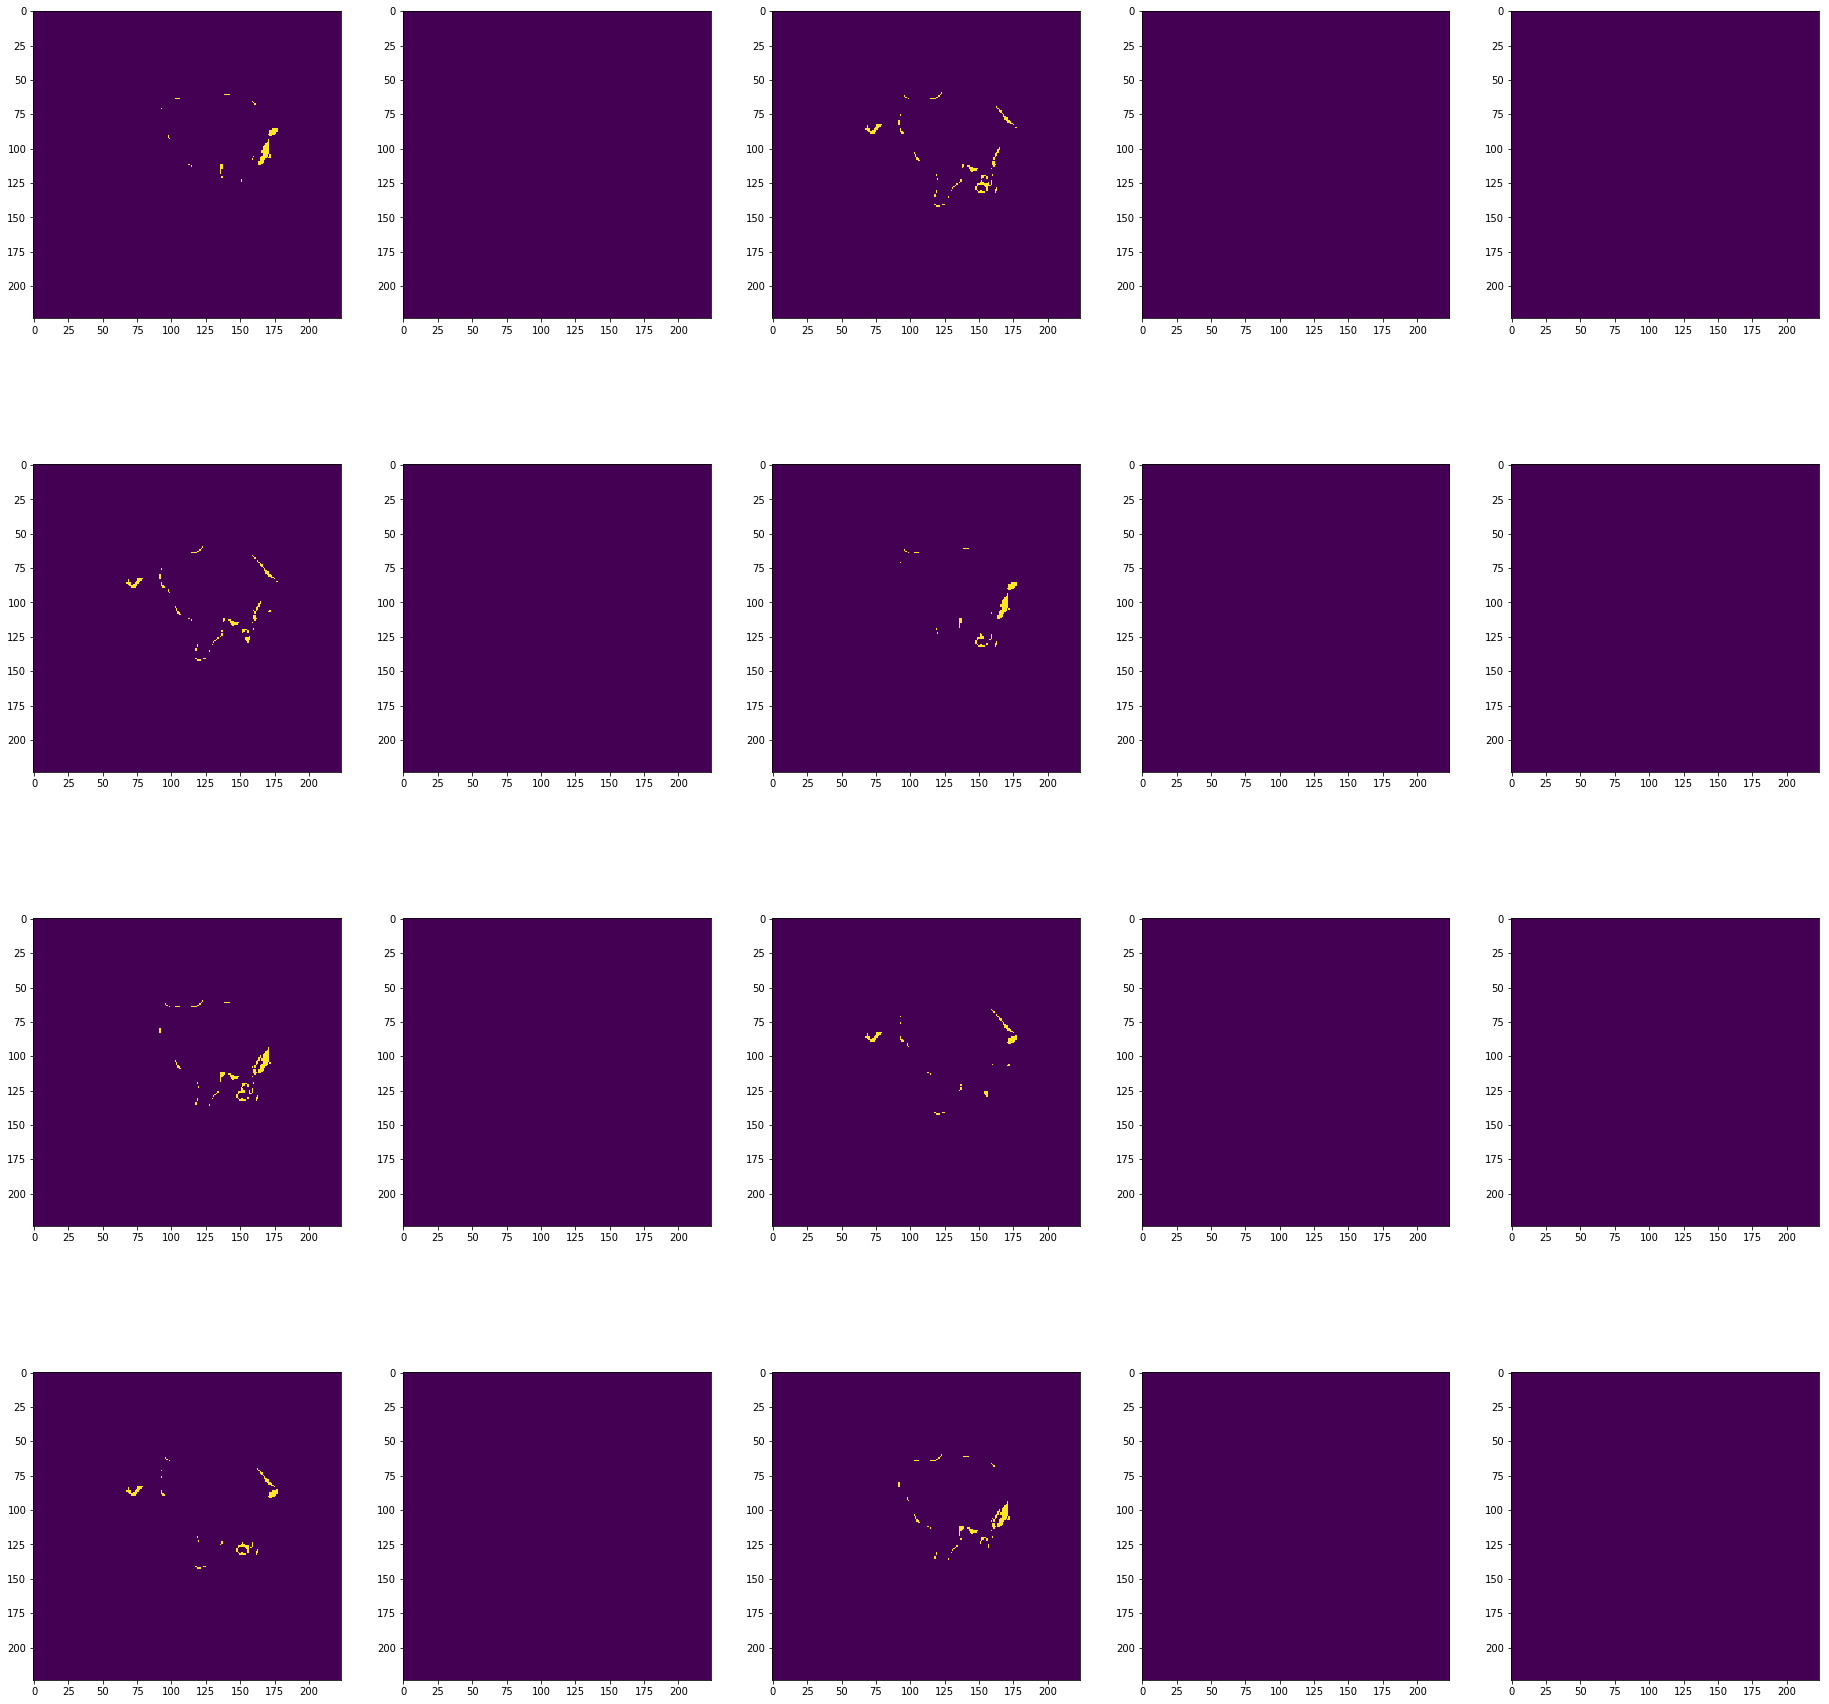

In [161]:
plt.figure(figsize=(32,32))
for a in range(ties_labels.shape[0]):
    for l in range(ties_labels.shape[-1]):
        plt.subplot(4, 5, 5*a + l + 1)
        plt.imshow(ties_labels[a, ..., l])

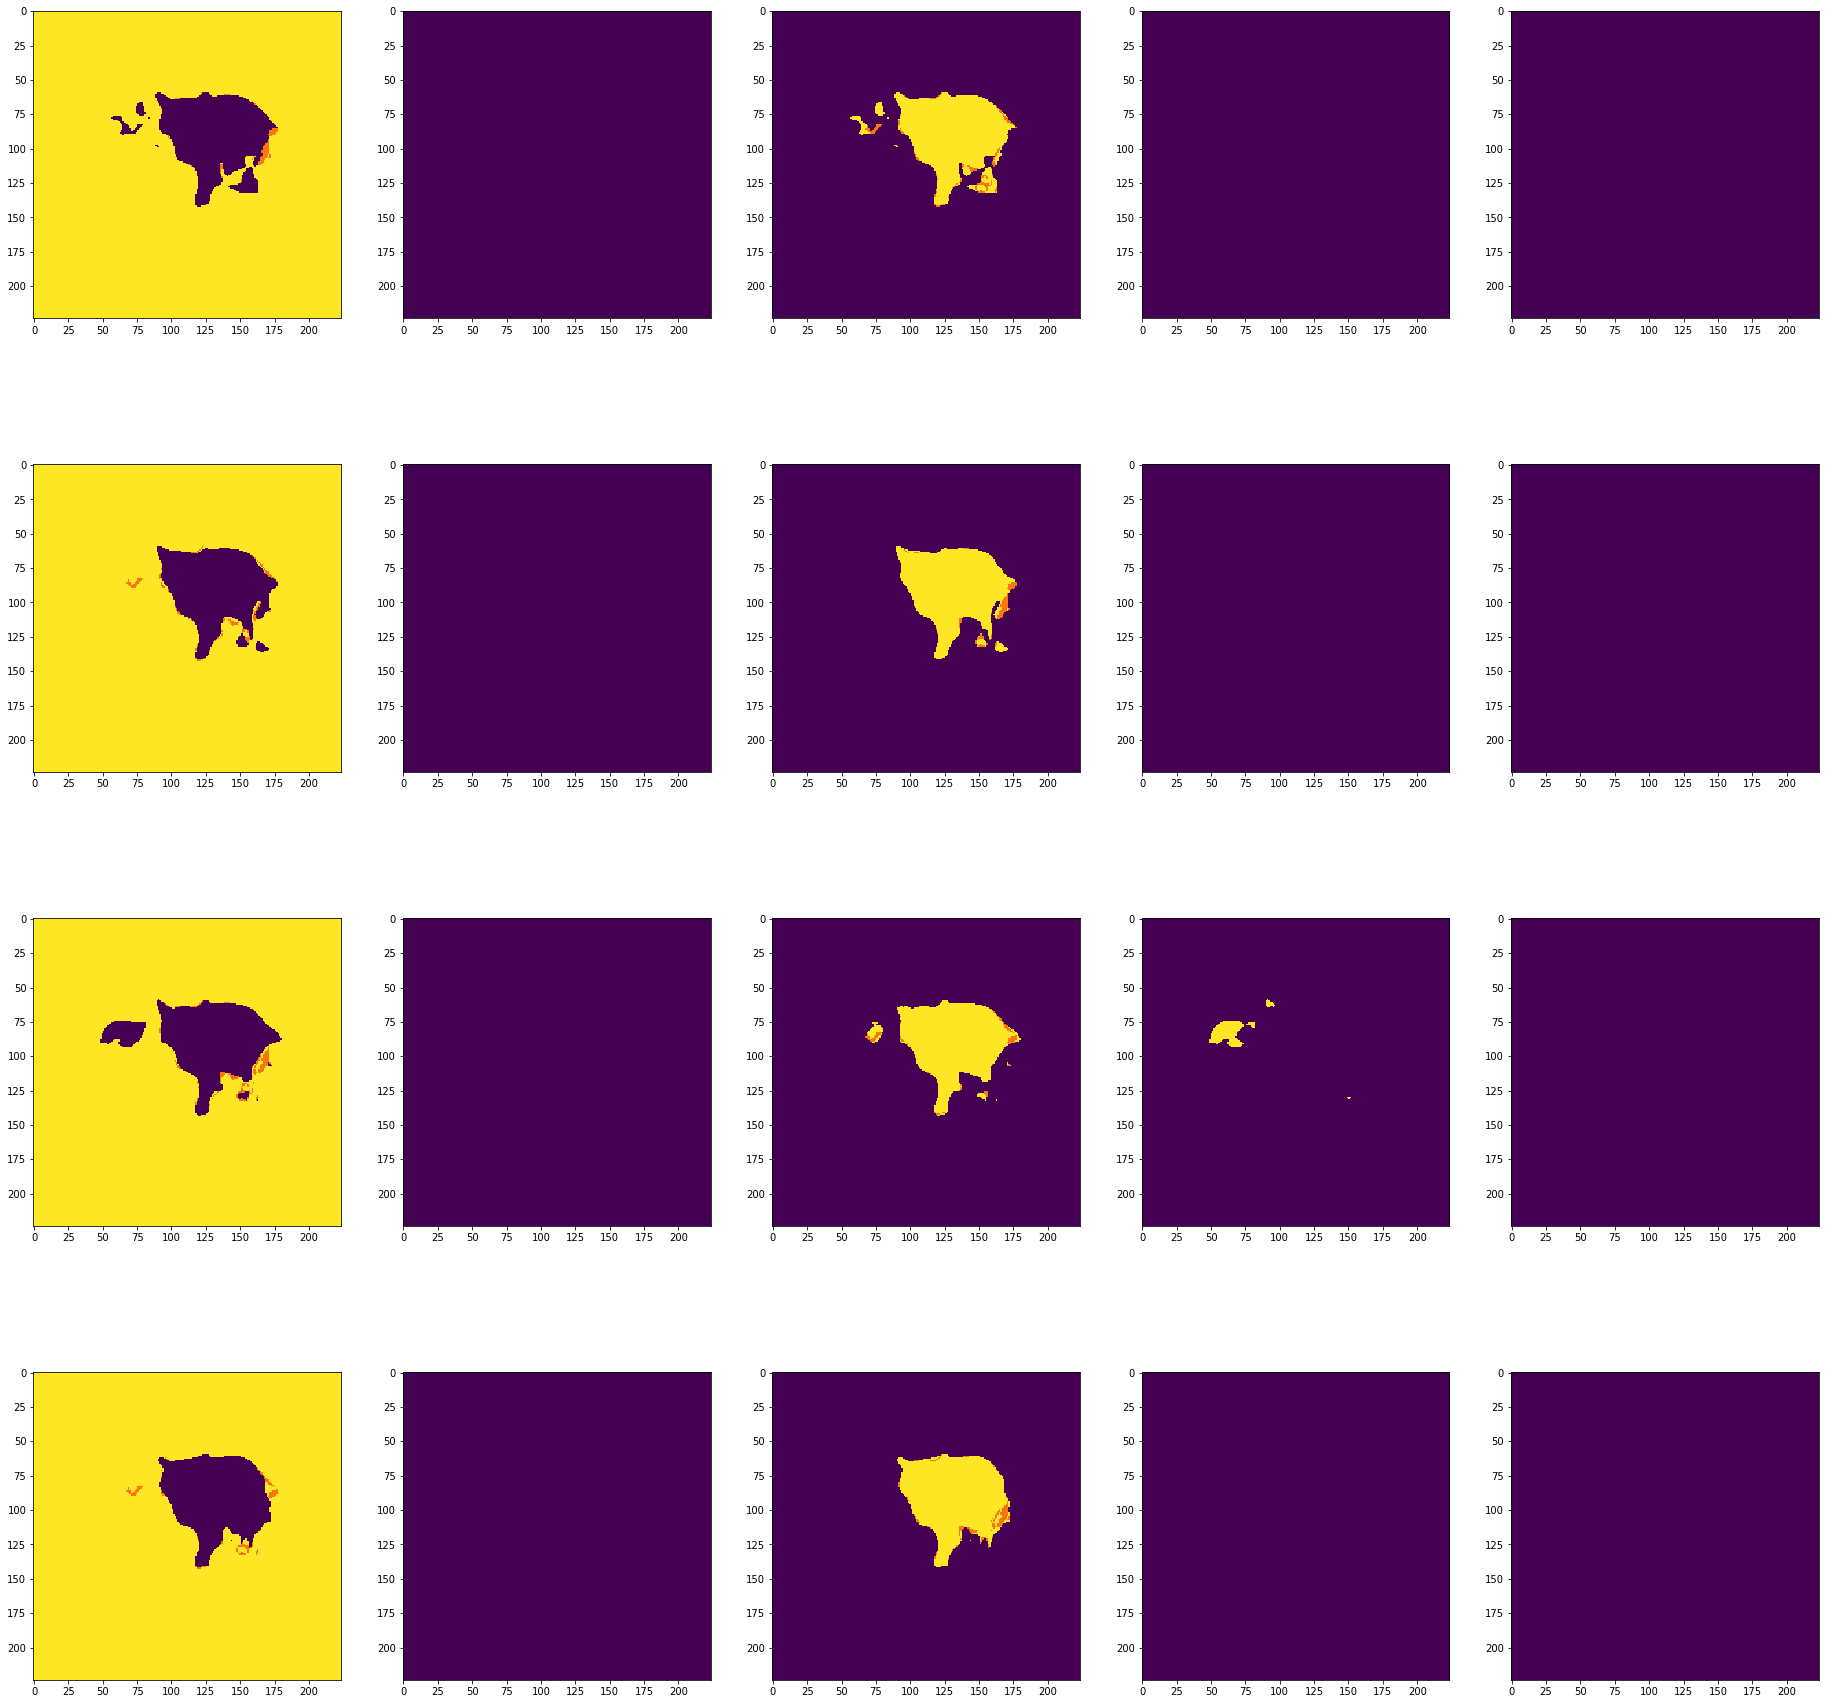

In [162]:
def visualize_binary_predictions(predictions):
    plt.figure(figsize=(32, 32))
    max_labels = predictions.shape[-1]
    max_agents = predictions.shape[0]
    
    mask = ties_labels
    for l, lab in enumerate(CHANNEL_NAMES):
        for ag in range(max_agents):
            plt.subplot(max_agents, max_labels, 1+ag*max_labels+l)
            plt.imshow(predictions[ag, ..., l])
            mask = np.tile(ties_preds[ag, :, :, l, np.newaxis], [1, 1, 4]).astype(np.float32)
            mask[:,:,1] = 0.0
            mask[:,:,2] = 0.0
            plt.imshow(mask, alpha=0.5)
visualize_binary_predictions(binary_predictions)

In [63]:
label_map[0, 100, 100]

2